# A3 - OpenJij core interface 入門 2

前回ではスピン数$N=5$の小さいシステムでのデモンストレーションを行いましたが、この章ではさらに大規模な計算を通してOpenJij core interfaceの機能、使い方をより詳しく見ていきます。

題材としてランダムイジング模型を取り上げます。この模型は、ハミルトニアンが
\begin{align}
H &= \sum_{i<j}J_{ij}\sigma_i \sigma_j + \sum_{i=1}^{N}h_i \sigma_i \\
\sigma_i &= \pm 1 (i=1 \cdots N)
\end{align}
で与えられて、$J_{ij}, h_{i}$が$(i,j)$に対して様々な値を持つ模型です。  
様々な種類の最適化問題がこのような模型の一番低いエネルギーを求める問題となりますが、エネルギーの最も低い状態を実現する$\sigma_i$を計算するには一般に非常に難しいです。

## 問題の定義 - Graph -

問題を定義してみましょう。`graph`の中の**Dense**モジュールが必要となります。
> `graph`中には基本的に**Dense**モジュールと**Sparse**モジュールがあり、今回の例のように全ての$J_{ij}$で値が定義されている場合には**Dense**モジュールが適しています。多くの$J_{ij}$の要素が0の場合には**Sparse**が適しています。使い方はどちらもほぼ変わりません。

In [115]:
import cxxjij.graph as G
#問題サイズを100とします。
N = 100

graph = G.Dense(N)
#sparseの場合
#graph = G.Sparse(N)

$J_{ij}, h_i$を設定します。今回は平均0、標準偏差1のGauss分布から生成される値を設定します。

In [116]:
!pip install numpy #乱数生成にnumpyを使います。

In [130]:
import numpy as np
mu, sigma = 0, 1

for i in range(N):
    for j in range(N):
        #Jijの値が大きくなりすぎてしまうので、全体の係数を1/Nしています。
        graph[i,j] = 0 if i == j else np.random.normal()/N

for i in range(N):
    graph[i] = np.random.normal()/N

ここで、縦磁場に関しては、`graph[i]`でも、`graph[i,i]`でもどちらでもアクセスできます。

また、イジングモデルの定義上、$J_{ij}$と$J_{ji}$は自動で同じ値となります。

In [118]:
graph[20] = 0.5
print(graph[20,20])
print(graph[20])
graph[12,34] = -0.6
print(graph[12,34])
print(graph[34,12])

0.5
0.5
-0.6
-0.6


**Dense** (および**Sprase**)は以下のメソッドを持っています。

- .gen_spin(seed)  
    乱数生成のためのseedを与えると、システムサイズ (ここでは$N=100$)分のスピン列を出力します。
    seedがない場合にはランダムにseedが決定されます。
- .size()  
    問題のサイズ($N$)を表示します。
- .adj_nodes(i)  
    インデックス$i$に隣接するノード一覧を表示します。
- .calc_energy(spin)  
    スピン列spinを与えられた際に、エネルギー
    \begin{align}  
    H &= \sum_{i<j}J_{ij}\sigma_i \sigma_j + \sum_{i=1}^{N}h_i \sigma_i
    \end{align}
    を計算します。

## システムの設定 - System -

続いて計算を行うためのシステムを定義します。ここで古典イジング模型か横磁場イジング模型か、また別の模型にするか等を選べます。

まずは古典イジング模型のシステムを作成してみます。`system.make_classical_ising`で作成できます。

In [119]:
import cxxjij.system as S

mysystem = S.make_classical_ising(graph.gen_spin(), graph)

ここで、引数の1つめにはランダムに生成したスピン、2つめはGraphそのものを代入しています。  
これにより初期スピン配位が`graph.gen_spin()`となる古典イジング模型のシステムが作成できます。
> `system.make_classical_ising`は内部でGraphとspinをそのまま保持しています。実装は[ここ](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/system/classical_ising.hpp#L37)にあり、63行目でメンバ変数
```cpp
graph::Spins spin;
const GraphType interaction;
```
が定義されています。  
古典イジング模型に関しては、行列演算ライブラリEigenを用いて最適化されたシステムである`system.make_classical_ising_Eigen`も用意しています。(実装は[ここ](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/system/classical_ising.hpp#L78))   
計算速度はこちらのほうが速いので**実際の用途では`system.make_classical_ising_Eigen`を使うことをおすすめします。**

システムに直接アクセスして、値を読むこともできます。

In [120]:
print(mysystem.spin)

[-1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1]


古典イジング模型以外にも様々なシステムが用意されており、用途別に使うことが出来ます。また、Systemによって初期化の方法は多少異なります。  
後ほど少しずつ紹介していきます。

## アルゴリズムの実行 -Updater, Algorithm-

Systemを定義した後はUpdaterを選択してAlgorithmを実行していきます。  
Systemに大して使用できるUpdaterは決められており、古典イジング模型に対するUpdaterは主に

- [SingleSpinFlip](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/single_spin_flip.hpp#L40) (メトロポリス・ヘイスティング法によるスピン1つずつのアップデート)
- [SwendsenWang](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/swendsen_wang.hpp#L45) (SwendsenWang法によるクラスターアップデート)

が用意されています。  
Algorithmを実行するにはまず**スケジュールリスト**が必要となるため、まずスケジュールリストを作成するところから始めます。

### スケジュールリスト

スケジュールリストは`(パラメータ, モンテカルロステップ数)`のリストで与えられ、パラメータにいれる値はSystemによって異なります。例えば古典イジング模型ならばパラメータとして温度の逆数である逆温度$\beta$を設定します。
例えばスケジュールリストとして

In [121]:
schedule_list = [(0.01, 10),(10, 80),(0.1, 30)]

と設定された場合、逆温度$\beta=0.01$で10モンテカルロステップ、$\beta=10$で80ステップ、$\beta=0.1$で30ステップの計120モンテカルロステップを実行することを意味します。

アニーリングを実行するにあたっては、逆温度は等比級数で増加させていくことが多いため、`utility`にある`make_classical_schedule_list`を使うと便利です。

In [122]:
import cxxjij.utility as U
schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 10)
print(schedule_list)

[((beta: 0.100000) mcs: 20), ((beta: 0.199474) mcs: 20), ((beta: 0.397897) mcs: 20), ((beta: 0.793701) mcs: 20), ((beta: 1.583223) mcs: 20), ((beta: 3.158114) mcs: 20), ((beta: 6.299605) mcs: 20), ((beta: 12.566053) mcs: 20), ((beta: 25.065966) mcs: 20), ((beta: 50.000000) mcs: 20)]


上の例では$\beta=0.1$から$\beta=50$まで、各温度で20モンテカルロステップ計算しながら10段階で温度を変えていくため、計200モンテカルロステップの計算となります。

### Algorithm

続いて、Algorithmを実行していきます。`Algorithm_[Updater]_run`のように書くことで、指定したUpdaterで計算を行うことができます。次例ではSingleSpinFlipを用います。

In [123]:
import cxxjij.algorithm as A
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)

一瞬で処理が終わりましたが、この間に計200モンテカルロステップの計算が終わっています。
> `A.Algorithm_SingleSpinFlip_run(mysystem, seed, schedule_list)`とすることで、seedを固定したまま計算を行うことができます。結果に再現性をもたせたい際に使うことができます。

callbackを使用することでAlgorithmの実行中に1モンテカルロステップごとのシステムを取得することができます。古典イジング模型の場合は、システムとパラメータ (逆温度)を引数を持つ関数を作成すれば良いです。

ためしにシステムのエネルギーの値を記録するcallbackを作ってみましょう

In [124]:
energies = []

def callback_log_energy(system, beta):
    #graphは以前にGraphモジュールにて定義したオブジェクトです
    energies.append(graph.calc_energy(system.spin))

このcallbackを用いて同じAlgorithmを実行します。

In [125]:
#スケジュールをもっと長く取ります (計20000モンテカルロステップ)
schedule_list = U.make_classical_schedule_list(0.1, 50, 200, 100)
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list, callback_log_energy)

記録したシステムのエネルギーを横軸をモンテカルロステップ、縦軸をエネルギーでプロットすると次のようになります。

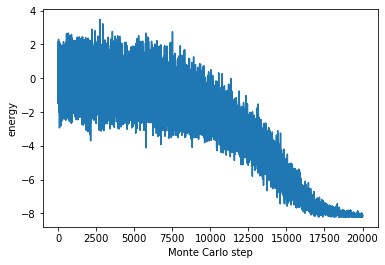

In [126]:
import matplotlib.pyplot as plt
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
plt.show()

このように、アニーリングが進むに連れエネルギーが低くなっているのが分かります。Algorithmの動作中にシステムの様子を知りたい時に有用です。

## 結果の取得 -Result-

`result.get_solution`で計算結果であるスピン列を取得できます。古典イジング模型の場合は直接`mysystem.spin`を参照すればスピン列を取得できますが、`result.get_solution`はそれ以外のシステムについてもスピン列を取得できます。

In [127]:
import cxxjij.result as R
print(R.get_solution(mysystem))

[1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1]


このスピン列がアニーリングによって得られた答えなので、ハミルトニアンの基底状態 (に近い状態)であることが期待されます。

## `system.make_classical_ising_Eigen` 

注釈で述べたように、古典イジング模型には線形代数ライブラリである[Eigen](http://eigen.tuxfamily.org/index.php?title=Main_Page)で実装された`system.make_classical_ising_Eigen`があります。`system.make_classical_ising`との計算速度をシステムサイズを変えて比較してみましょう。

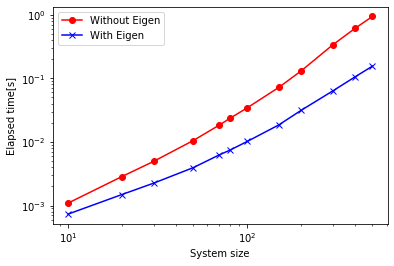

In [129]:
import time

N_list = [10, 20, 30, 50, 70, 80, 100, 150, 200, 300, 400, 500]

#計算時間
calctime = []
#計算時間 (Eigen実装)
calctime_eigen = []

for N in N_list:
    #Graphの初期化
    graph = G.Dense(N)
    for i in range(N):
        for j in range(N):
            #Jijの値が大きくなりすぎてしまうので、全体の係数を1/Nしています。
            graph[i,j] = 0 if i == j else np.random.normal()/N

    for i in range(N):
        graph[i] = np.random.normal()/N
    
    #Systemの初期化
    mysystem = S.make_classical_ising(graph.gen_spin(), graph)
    mysystem_eigen = S.make_classical_ising_Eigen(graph.gen_spin(), graph)
    
    #スケジュールリスト (2000モンテカルロステップ)
    schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 100)
    
    t1 = time.time()
    #アニーリング (Eigenなし)
    A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)
    t2 = time.time()
    calctime.append(t2-t1)
    
    t1 = time.time()
    #アニーリング (Eigenあり)
    A.Algorithm_SingleSpinFlip_run(mysystem_eigen, schedule_list)
    t2 = time.time()
    calctime_eigen.append(t2-t1)

#結果を両対数プロット
plt.plot(N_list, calctime, 'ro-', label='Without Eigen')
plt.plot(N_list, calctime_eigen, 'bx-', label='With Eigen')
plt.xlabel('System size')
plt.ylabel('Elapsed time[s]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

全体的にEigen実装のほうが計算が早く、大きいシステムサイズではほぼ10倍ほどのスピード差があります。

## C++ core interface

C++ core interfaceでも上記とほぼ同じことが可能ですが、多少の違いがあり、

- seed値を入れる引数には、乱数生成器 (C++11 random)を代入する必要があります。今までのコードはC++で次のようになります。
- Graphクラスで、$J_{ij}, h_i$へのアクセス方法が多少異なります。